# Bohndesliga Table Style

Bohndesliga is a german online broadbast by [Rocket Beans TV](https://rocketbeans.tv/). In their show they discuss the recent games of the Bundesliga (in german). They have created a nice visual style to show the Bundesliga table that we are going to recreate with plottable (with a few details adjusted).

You can view an example of the table we are going to recreate at this [timestamped video](https://youtu.be/VhLTS8J1N_M?t=5578).

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plottable import ColDef, Table
from plottable.plots import image

## Getting the data

In [2]:
FIVETHIRTYEIGHT_URLS = {
    "SPI_MATCHES": "https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv",
    "SPI_MATCHES_LATEST": "https://projects.fivethirtyeight.com/soccer-api/club/spi_matches_latest.csv",
}

df = pd.read_csv(FIVETHIRTYEIGHT_URLS["SPI_MATCHES_LATEST"])

In [4]:
bl = df.loc[df.league == "German Bundesliga"].dropna()


print(bl.head(10))

     season        date  league_id             league  \
497    2022  2022-08-05       1845  German Bundesliga   
514    2022  2022-08-06       1845  German Bundesliga   
515    2022  2022-08-06       1845  German Bundesliga   
516    2022  2022-08-06       1845  German Bundesliga   
517    2022  2022-08-06       1845  German Bundesliga   
518    2022  2022-08-06       1845  German Bundesliga   
573    2022  2022-08-06       1845  German Bundesliga   
616    2022  2022-08-07       1845  German Bundesliga   
630    2022  2022-08-07       1845  German Bundesliga   
672    2022  2022-08-12       1845  German Bundesliga   

                        team1              team2   spi1   spi2   prob1  \
497       Eintracht Frankfurt      Bayern Munich  68.47  91.75  0.1350   
514                VfL Bochum              Mainz  60.73  68.88  0.3568   
515  Borussia Monchengladbach     TSG Hoffenheim  69.38  66.77  0.4872   
516             VfL Wolfsburg      Werder Bremen  68.18  59.82  0.5319   
51

## Data Processing

In [5]:
# 计算总积分
def add_points(df: pd.DataFrame) -> pd.DataFrame:
    df["pts_home"] = np.where(
        df["score1"] > df["score2"], 3, np.where(df["score1"] == df["score2"], 1, 0)
    )
    df["pts_away"] = np.where(
        df["score1"] < df["score2"], 3, np.where(df["score1"] == df["score2"], 1, 0)
    )
    
    return df


def get_wins_draws_losses(games: pd.DataFrame) -> pd.DataFrame:
    return (
        games.rename({"pts_home": "pts", "team1": "team"}, axis=1)
        .groupby("team")["pts"]
        .value_counts()
        .add(
            games.rename({"pts_away": "pts", "team2": "team"}, axis=1)
            .groupby("team")["pts"]
            .value_counts(),
            fill_value=0,
        )
        .astype(int)
        .rename("count")
        .reset_index(level=1)
        .pivot(columns="pts", values="count")
        .rename({0: "L", 1: "D", 3: "W"}, axis=1)[["W", "D", "L"]]
    )

In [6]:
bl = add_points(bl)

In [7]:
perform = (
    bl.groupby("team1")[[
        "pts_home",
        "score1",
        "score2",
        "xg1",
        "xg2",
    ]]
    .sum()
    .set_axis(
        [
            "pts",
            "gf",
            "ga",
            "xgf",
            "xga",
        ],
        axis=1,
    )
    .add(
        bl.groupby("team2")[[
            "pts_away",
            "score2",
            "score1",
            "xg2",
            "xg1",
        ]]
        .sum()
        .set_axis(
            [
                "pts",
                "gf",
                "ga",
                "xgf",
                "xga",
            ],
            axis=1,
        )
    )
)

perform.index.name = "team"

perform["gd"] = perform["gf"] - perform["ga"]

perform = perform[
    [
        "pts",
        "gd",
        "gf",
        "ga",
        "xgf",
        "xga",
    ]
]

perform["games"] = bl.groupby("team1").size().add(bl.groupby("team2").size())

In [8]:
wins_draws_losses = get_wins_draws_losses(bl)
perform = pd.concat([perform, wins_draws_losses], axis=1)

In [9]:
perform

,pts,gd,gf,ga,xgf,xga,games,W,D,L
team,,,,,,,,,,
1. FC Union Berlin,62,13.0,51.0,38.0,35.93,43.06,34,18,8,8
Bayer Leverkusen,50,8.0,57.0,49.0,53.62,48.20,34,14,8,12
Bayern Munich,71,54.0,92.0,38.0,84.93,40.12,34,21,8,5
Borussia Dortmund,71,39.0,83.0,44.0,75.96,42.69,34,22,5,7
Borussia Monchengladbach,43,-3.0,52.0,55.0,53.05,58.88,34,11,10,13
Eintracht Frankfurt,50,6.0,58.0,52.0,54.30,46.00,34,13,11,10
FC Augsburg,34,-21.0,42.0,63.0,36.67,66.05,34,9,7,18
FC Cologne,42,-5.0,49.0,54.0,52.18,43.29,34,10,12,12
Hertha Berlin,29,-27.0,42.0,69.0,42.39,60.63,34,7,8,19


In [10]:
# mapping teamnames to logo paths

club_logo_path = Path("bundesliga_crests_22_23")
club_logo_files = list(club_logo_path.glob("*.png"))
club_logos_paths = {f.stem: f for f in club_logo_files}

In [11]:
perform = perform.reset_index()

# Add a column for crests
perform.insert(0, "crest", perform["team"])
perform["crest"] = perform["crest"].replace(club_logos_paths)

# sort by table standings
perform = perform.sort_values(by=["pts", "gd", "gf"], ascending=False)

for colname in ["gd", "gf", "ga"]:
    perform[colname] = perform[colname].astype("int32")

perform["goal_difference"] = perform["gf"].astype(str) + ":" + perform["ga"].astype(str)

perform["rank"] = list(range(1, 19))

## Building the Bohndesliga Table

In [12]:
row_colors = {
    "top4": "#2d3636",
    "top6": "#516362",
    "playoffs": "#8d9386",
    "relegation": "#c8ab8d",
    "even": "#627979",
    "odd": "#68817e",
}

bg_color = row_colors["odd"]
text_color = "#e0e8df"

table_cols = ["crest", "team", "games", "W", "D", "L", "goal_difference", "gd", "pts"]

In [13]:
perform[table_cols]

,crest,team,games,W,D,L,goal_difference,gd,pts
2,bundesliga_crests_22_23\Bayern Munich.png,Bayern Munich,34,21,8,5,92:38,54,71
3,bundesliga_crests_22_23\Borussia Dortmund.png,Borussia Dortmund,34,22,5,7,83:44,39,71
10,bundesliga_crests_22_23\RB Leipzig.png,RB Leipzig,34,20,6,8,64:41,23,66
0,bundesliga_crests_22_23\1. FC Union Berlin.png,1. FC Union Berlin,34,18,8,8,51:38,13,62
11,bundesliga_crests_22_23\SC Freiburg.png,SC Freiburg,34,17,8,9,51:44,7,59
1,bundesliga_crests_22_23\Bayer Leverkusen.png,Bayer Leverkusen,34,14,8,12,57:49,8,50
5,bundesliga_crests_22_23\Eintracht Frankfurt.png,Eintracht Frankfurt,34,13,11,10,58:52,6,50
16,bundesliga_crests_22_23\VfL Wolfsburg.png,VfL Wolfsburg,34,13,10,11,57:48,9,49
9,bundesliga_crests_22_23\Mainz.png,Mainz,34,12,10,12,54:55,-1,46
4,bundesliga_crests_22_23\Borussia Monchengladba...,Borussia Monchengladbach,34,11,10,13,52:55,-3,43


### Setting up the ColumnDefinitions

With the ColumnDefinitions we we can adjust the tables style by supplying keywords such as `title`, `width`, `formatters` and `textprops`.

```{seealso}
You can view more details in the [Using ColumnDefinition Notebook](../notebooks/column_definition.ipynb).
```

In [14]:
table_col_defs = [
    ColDef("rank", width=0.5, title=""),
    ColDef("crest", width=0.35, plot_fn=image, title=""),
    ColDef("team", width=2.5, title="", textprops={"ha": "left"}),
    ColDef("games", width=0.5, title="Games"),
    ColDef("W", width=0.5),
    ColDef("D", width=0.5),
    ColDef("L", width=0.5),
    ColDef("goal_difference", title="Goals"),
    ColDef("gd", width=0.5, title="", formatter="{:+}"),
    ColDef("pts", border="left", title="Points"),
]

### Plotting the Table

```{seealso}
Here we use various keywords of `Table` to control its appearance. You can view more details in the [Styling a Table Notebook](../notebooks/column_definition.ipynb).
```

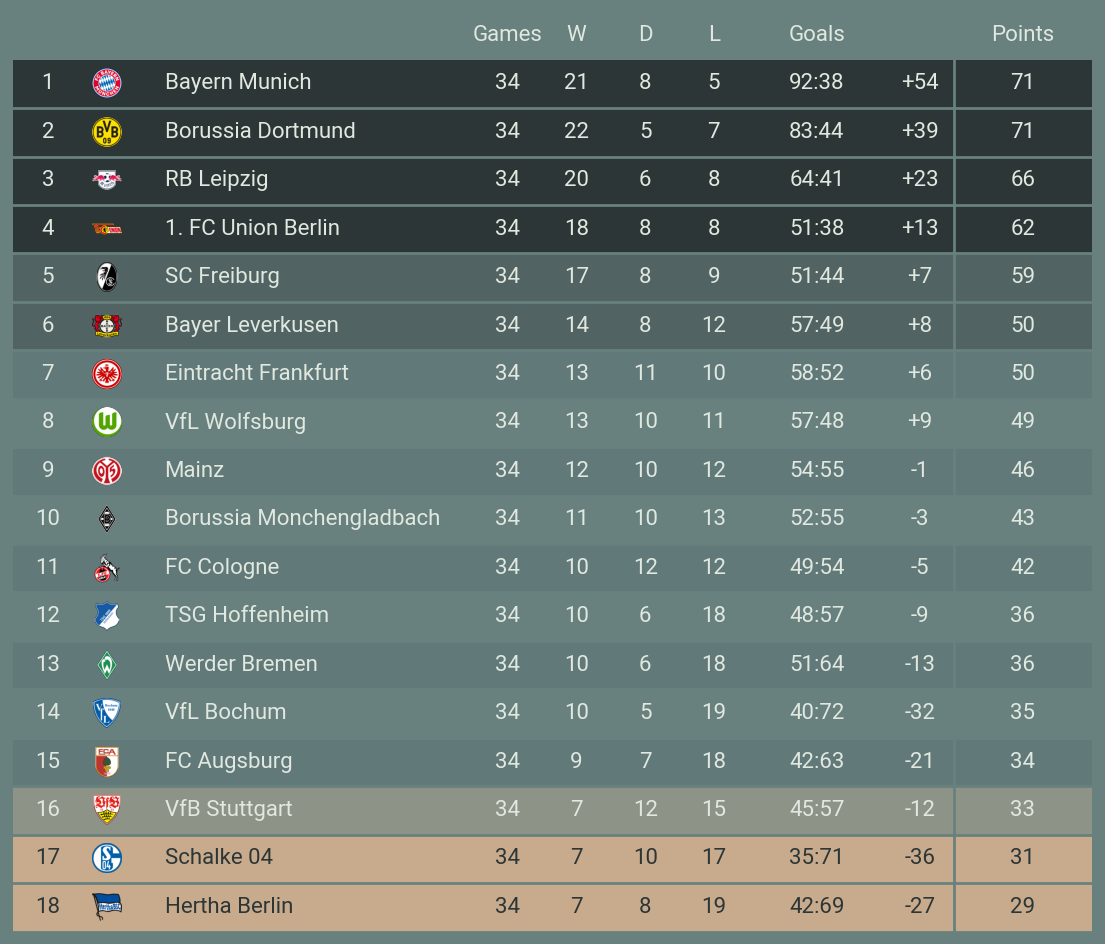

In [15]:
fig, ax = plt.subplots(figsize=(14, 12))

plt.rcParams["text.color"] = text_color
plt.rcParams["font.family"] = "Roboto"

fig.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

table = Table(
    perform,
    column_definitions=table_col_defs,
    row_dividers=True,
    col_label_divider=False,
    footer_divider=True,
    index_col="rank",
    columns=table_cols,
    even_row_color=row_colors["even"],
    footer_divider_kw={"color": bg_color, "lw": 2},
    row_divider_kw={"color": bg_color, "lw": 2},
    column_border_kw={"color": bg_color, "lw": 2},
    textprops={"fontsize": 16, "ha": "center", "fontname": "Roboto"},
)

for idx in [0, 1, 2, 3]:
    table.rows[idx].set_facecolor(row_colors["top4"])
    
for idx in [4, 5]:
    table.rows[idx].set_facecolor(row_colors["top6"])
    
table.rows[15].set_facecolor(row_colors["playoffs"])

for idx in [16, 17]:
    table.rows[idx].set_facecolor(row_colors["relegation"])
    table.rows[idx].set_fontcolor(row_colors["top4"])

    
fig.savefig(
    "images/bohndesliga_table_recreation.png",
    facecolor=fig.get_facecolor(),
    dpi=200,
)

Note on the slightly adjusted details:  
I chose to make the light text a little lighter than the original and used the background color of the top4 rows as the fontcolor for the bottom two rows because I think the higher contrast makes it a little bit easier to read.  
I also chose to stick to the light text on the background for the header row to keep this consistent.  
Finally I added a little clarity by adding titles to the points and goal difference columns. This also allowed me to not highlight the points additionally with a bold weight.